Code based on Appendix A, using Clebsch-Gordan factors (Section A.5)

# 1) Packages

In [1]:
import numpy as np
from scipy.special import expit
from scipy.linalg import null_space
import warnings
import matplotlib.pyplot as plt

# 2) Units and Physical constants

- Energy: eV
- Temperature: K
- Time: ns
- Length: Å
- Charge: zC (zeptoCoulomb, $10^{-21}$ C) 

Leads to:

- Current: pA

In [2]:
kB = 8.617333262e-05  # Boltzmann, eV K^-1
e = 1.60217663e2  # elementary charge, zC

# 3) Data: Dyson orbitals

This will be replaced by a reader of cube files cointaining the Dyson orbitals.

Here, as an example, I manually create the Dyson orbitals for the case of pentacene.

In [3]:
# read xyz file
def read_xyz(filename):
    with open(filename, "r") as f:
        lines = f.readlines()

    atoms = []
    for line in lines[2:]:
        parts = line.split()
        if len(parts) < 4:
            continue
        elem = parts[0]
        x, y, z = map(float, parts[1:4])
        atoms.append((elem, np.array([x, y, z])))

    return atoms


# carbon 2pz orbital
def C_2pz_orbital(x, y, z, Xi, Yi, Zi, r0=0.325):
    xdiff = x - Xi
    ydiff = y - Yi
    zdiff = z - Zi
    rdiff_abs = np.sqrt(xdiff**2 + ydiff**2 + zdiff**2)

    return zdiff * np.exp(-rdiff_abs / r0)


# Dyson orbital from C-pz coefficients
def Dyson_Cpz(x, y, z, sites, Dyson_coeff):
    dyson = 0
    for i, (Xi, Yi, Zi) in enumerate(sites):
        dyson += Dyson_coeff[i] * C_2pz_orbital(x, y, z, Xi, Yi, Zi)

    return dyson

In [4]:
# positions of carbon sites
atoms = read_xyz("pentacene_aiidalab.xyz")
sites = np.array([pos for elem, pos in atoms if elem == "C"])

# molecular orbitals = Dyson orbitals (site basis)
HOMO = [
    -0.15405770246342296,
    0.1540577024634226,
    0.1879021570861905,
    -0.11277806550055434,
    0.11277806550055418,
    -0.1879021570861906,
    -0.3254560829250698,
    0.04127963696286763,
    -0.041279636962867246,
    0.3254560829250698,
    0.3758043141723793,
    0.04127963696286916,
    -0.04127963696286835,
    -0.37580431417237903,
    -0.3254560829250673,
    -0.1127780655005539,
    0.11277806550055428,
    0.3254560829250675,
    0.18790215708618802,
    0.1540577024634217,
    -0.1540577024634214,
    -0.1879021570861885,
]
LUMO = [
    -0.1540577024634225,
    -0.15405770246342276,
    0.1879021570861892,
    0.11277806550055364,
    0.11277806550055404,
    0.18790215708618965,
    -0.3254560829250685,
    -0.04127963696286744,
    -0.04127963696286818,
    -0.3254560829250694,
    0.3758043141723783,
    -0.04127963696286861,
    -0.04127963696286786,
    0.37580431417237903,
    -0.3254560829250694,
    0.1127780655005535,
    0.11277806550055383,
    -0.3254560829250673,
    0.18790215708619074,
    -0.15405770246342188,
    -0.15405770246342282,
    0.18790215708618915,
]


# Dyson orbitals
## S0 <-> D0-
def Dyson_S0_D0m(x, y, z):
    return Dyson_Cpz(x, y, z, sites, LUMO)


## S0 <-> D0+
def Dyson_S0_D0p(x, y, z):
    return Dyson_Cpz(x, y, z, sites, HOMO)

# 4) Main

## 4.1) Functions

In [5]:
# build dictionary of Clebsch-Gordan factors
""" 
Eq. (A31), accounting also for the charge selection rules

(Mi,Mf) : CG factor Mi->Mf
"""


def build_CG_dict(Mlist, Slist, qlist):
    glist = [2 * S + 1 for S in Slist]

    CG_dict = {}
    for i, Mi in enumerate(Mlist):
        for f, Mf in enumerate(Mlist):
            # charge selection rules
            dq = qlist[f] - qlist[i]
            if abs(dq) != 1:
                continue

            gi, gf = glist[i], glist[f]
            CG_dict[(Mi, Mf)] = max(gi, gf) / gi

    return CG_dict


# Fermi-Dirac function
"""
Inline equation after Eq. (A11)
"""


def nFD(E, T):
    beta = 1 / (kB * T)

    return expit(-beta * E)


# build Gsub: tunneling rate for charge transfer with substrate
""" 
Eq. (A18), with mu_s=0 because mu_s is already incorporated
    in the energies
CG factors, Eq. (A31), also included
"""


def build_Gsub(Mlist, eta_s, N_dict, Elist, CG_dict, T):
    dim = len(Mlist)

    Gsub = np.zeros((dim, dim))
    for (Mi, Mf), CG in CG_dict.items():
        i, f = Mlist.index(Mi), Mlist.index(Mf)
        Ei, Ef = Elist[i], Elist[f]
        N = N_dict.get((Mi, Mf), N_dict.get((Mf, Mi)))
        Gsub[i, f] += CG * eta_s * N * nFD(Ef - Ei, T)

    return Gsub


# build Gtip: tunneling rate for charge transfer with tip
""" 
Eq. (A20), with mu_s=0 because mu_s is already incorporated
    in the energies
CG factors, Eq. (A31), also included

Note: no need to use normalized Dyson orbitals, instead use
    Dyson_dict and remove the norm
"""


def build_Gtip(Mlist, eta_t, Dyson_dict, Elist, qlist, CG_dict, T):
    def Gtip_func(x, y, z, eV):
        dim = len(Mlist)

        Gtip = np.zeros((dim, dim))
        for (Mi, Mf), CG in CG_dict.items():
            i, f = Mlist.index(Mi), Mlist.index(Mf)
            Ei, Ef = Elist[i], Elist[f]
            dq = qlist[f] - qlist[i]
            Dyson_func = Dyson_dict.get((Mi, Mf), Dyson_dict.get((Mf, Mi)))
            Dyson = Dyson_func(x, y, z)

            Gtip[i, f] += CG * eta_t * nFD(Ef - Ei + dq * eV, T) * abs(Dyson) ** 2

        return Gtip

    return Gtip_func


# build total Gamma matrix
""" 
Gtot = Gtip + Gsub + ... (Gothers, optional)
"""


def build_Gtot(Gtip, Gsub, Gothers=[]):
    def Gtot_func(x, y, z, eV):
        Gtot = Gtip(x, y, z, eV) + Gsub
        for G in Gothers:
            Gtot += G

        return Gtot

    return Gtot_func


# build W matrix
""" 
Eq. (A24)
"""


def build_W(Gtot):
    def W_func(x, y, z, eV):
        Gamma = Gtot(x, y, z, eV)
        W = Gamma.T.copy()
        np.fill_diagonal(W, 0)
        np.fill_diagonal(W, -Gamma.sum(axis=1))

        return W

    return W_func


# find null space of W
""" 
Eq. (A25), with normalization constraint and some checks
"""


def find_null_space(W):
    Peq_all = null_space(W)

    # check null-space vectors found
    n_Peq = Peq_all.shape[1]
    if n_Peq == 0:
        raise ValueError("No null-space vector found.")
    if n_Peq > 1:
        warnings.warn(
            f"Multiple null-space vectors found ({n_Peq})."
            "Proceeding with one of them (the first)."
        )

    # use first null-space vector (if multiple vectors are found)
    Peq = Peq_all[:, 0]
    # normalize
    Peq /= np.sum(Peq)

    # check positivity
    tol = 1e-12
    if np.any(Peq < -tol):
        raise ValueError(
            "Some entries of the null-space vector are negative"
            " beyond numerical tolerance {tol}."
        )

    return Peq


# compute Ieq
""" 
Eq. (A27), using some tricks to avoid explicit sums
"""


def calc_Ieq(Peq, Gsub, qlist):
    qarray = np.array(qlist)

    term1 = (Gsub @ qarray) @ Peq
    term2 = sum(Gsub.T @ (Peq * qarray))

    Ieq = e * (term1 - term2)

    return Ieq

## 4.2) Inputs

In [6]:
# many-body states
## labels
Mlist = ["S0", "D0+", "D0-"]
## charge
qlist = [0, 1, -1]
## spin
Slist = [0, 1 / 2, 1 / 2]
## energies, eV
""" 
Energies chosen to match addition energies with mu_s=0, 
    see Eq. (21)
"""
Elist = [0, 0.4, 0.8]

# rate prefactors, ns^-1
""" 
In the regime where surface-molecule dominates:
- eta_s does not influence Ieq (!)
- Ieq is proportional to eta_t
"""
eta_s = 1e13
eta_t = 1e11

# temperature, K
T = 100

# dictionary of Dyson orbitals
""" 
(M,M') : Dyson M<->M'

Important property:
|Dyson orbital M->M'| = |Dyson orbital M'->M|
Therefore, each entry of the dictionary corresponds to the M<->M' Dyson orbital 
"""
Dyson_dict = {
    ("S0", "D0+"): Dyson_S0_D0p,
    ("S0", "D0-"): Dyson_S0_D0m,
}

## 4.3) Build W

In [7]:
# dictionary of norms
""" 
Eq. (A16), but without sum over spins since this code uses
    the Clebsch-Gordan factors

TO DO: compute norms from cube files + create dictionary
    automatically

In this example, I compute norms from the data in site 
    basis and create the dictionary manually
"""
N_S0_D0p = sum([x**2 for x in HOMO])
N_S0_D0m = sum([x**2 for x in LUMO])
N_dict = {
    ("S0", "D0+"): N_S0_D0p,
    ("S0", "D0-"): N_S0_D0m,
}

# dictionary of Clebsch-Gordan factors
CG_dict = build_CG_dict(Mlist, Slist, qlist)
# print(CG_dict)

# build Gsub
Gsub = build_Gsub(Mlist, eta_s, N_dict, Elist, CG_dict, T)
# print(tabulate(Gsub, tablefmt="fancy_grid"))

# build Gtip
Gtip = build_Gtip(Mlist, eta_t, Dyson_dict, Elist, qlist, CG_dict, T)
# x,y,z = 9,12,11
# eV = 0.9
# print(tabulate(Gtip(x,y,z,eV), tablefmt="fancy_grid"))

# build Gtot
Gtot = build_Gtot(Gtip, Gsub)
# print(tabulate(Gtot(x,y,z,eV), tablefmt="fancy_grid"))

# build W
W = build_W(Gtot)
# print(tabulate(W(x,y,z,eV), tablefmt="fancy_grid"))

## 4.4) I(V) curves

In [8]:
x, y, z = 10, 11, 12.5
eV_values = np.linspace(-1.2, 1.2, 200)

Ieq_values = np.array(
    [calc_Ieq(find_null_space(W(x, y, z, eV)), Gsub, qlist) for eV in eV_values]
)

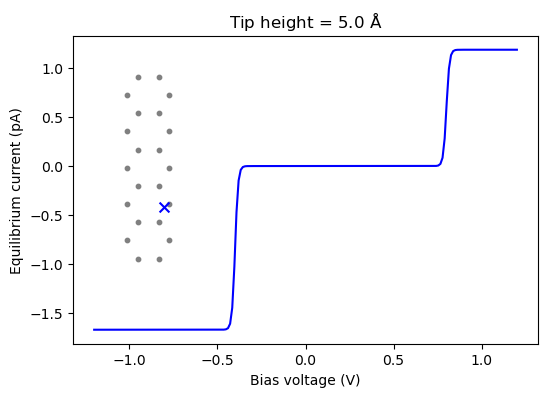

In [9]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(eV_values, Ieq_values, color="blue")
ax.set_xlabel("Bias voltage (V)")
ax.set_ylabel("Equilibrium current (pA)")
ax.set_title(f"Tip height = ${z - np.mean(sites[:, 2]):.1f}$ Å")

# inset
axins = fig.add_axes([0.0, 0.3, 0.5, 0.5])  # adjust as needed
axins.scatter(sites[:, 0], sites[:, 1], color="gray", s=10, clip_on=False)
axins.scatter(x, y, color="blue", s=50, marker="x")
axins.set_aspect("equal", adjustable="box")
axins.set_xticks([])
axins.set_yticks([])
for spine in axins.spines.values():
    spine.set_visible(False)

plt.show()

## 4.5) I(x,y) constant-height maps

In [10]:
# Fixed parameters
z_fixed = 12.5
eV_fixed = -0.6

# Define grid range (with small margin)
margin = 2
x_min, x_max = sites[:, 0].min() - margin, sites[:, 0].max() + margin
y_min, y_max = sites[:, 1].min() - margin, sites[:, 1].max() + margin

# Define grid resolution
nx, ny = 100, 100
x_vals = np.linspace(x_min, x_max, nx)
y_vals = np.linspace(y_min, y_max, ny)

# Compute Ieq(x, y) map
Ieq_map = np.zeros((ny, nx))
for i, y in enumerate(y_vals):
    for j, x in enumerate(x_vals):
        Peq = find_null_space(W(x, y, z_fixed, eV_fixed))
        Ieq_map[i, j] = calc_Ieq(Peq, Gsub, qlist)

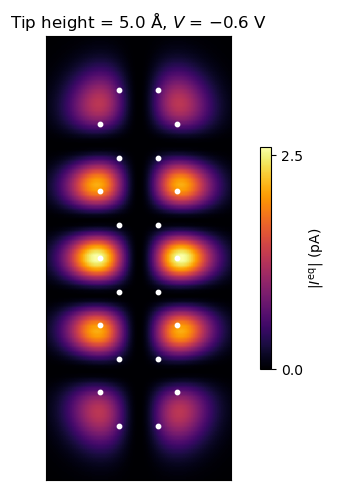

In [13]:
plt.figure(figsize=(6, 5))
plt.imshow(
    np.abs(Ieq_map),
    extent=[x_min, x_max, y_min, y_max],
    origin="lower",
    cmap="inferno",
    aspect="equal",
)
min_tick = np.floor(np.abs(Ieq_map).min() * 10) / 10
max_tick = np.floor(np.abs(Ieq_map).max() * 10) / 10
cbar = plt.colorbar(label="|$I^{\mathrm{eq}}$| (pA)", shrink=0.5)
cbar.set_ticks([min_tick, max_tick])
plt.scatter(sites[:, 0], sites[:, 1], color="white", s=10)
plt.title(
    rf"Tip height = ${z_fixed - np.mean(sites[:, 2]):.1f}$ Å, $V$ = ${eV_fixed:.1f}$ V"
)
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()